<h1> MIDS W207 Final</h1>

<h3> Group Members </h3>
Ben Attix <br>
Justin Plumley <br>
Dan Watson

<h3> Kaggle Competition </h3>
Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

<h3> Evaluation </h3>
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as:
logerror=log(Zestimate)−log(SalePrice)
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

<h5> Competition Website </h5>
https://www.kaggle.com/c/zillow-prize-1#description

<h2> Load libraries, data, and test output

In [19]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
train_df = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("properties_2016.csv")
print(prop_df.shape)
print(train_df.shape)
#df outputs
#prop_df.head()
#train_df.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


In [4]:
# Test submission output
#test_sub = pd.read_csv("sample_submission.csv")
#for i in test_sub.columns[test_sub.columns != "ParcelId"]:
    #test_sub[i] = np.mean(train_df['logerror'])
#test_sub.to_csv('test_submission.csv', index= False, float_format='%.4f')

<H2> EDA </H2> <br>
Many ideas and code taken from following EDA Kernels:
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize (python)
https://www.kaggle.com/philippsp/exploratory-analysis-zillow (R)
https://www.kaggle.com/captcalculator/a-very-extensive-zillow-exploratory-analysis (R)
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity (python)

<H5> Start with train dataframe </H5>
<H5> Log Error </H5>

In [5]:
train_df.describe()

,parcelid,logerror
count,9.027500e+04,90275.000000
mean,1.298466e+07,0.011457
std,2.504510e+06,0.161079
min,1.071174e+07,-4.605000
25%,1.155950e+07,-0.025300
50%,1.254734e+07,0.006000
75%,1.422755e+07,0.039200
max,1.629608e+08,4.737000


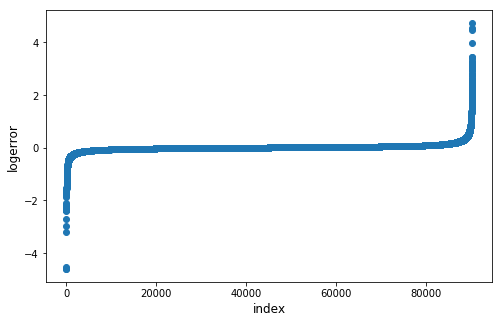

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Log error is quite good for vast majority- outliers are key here

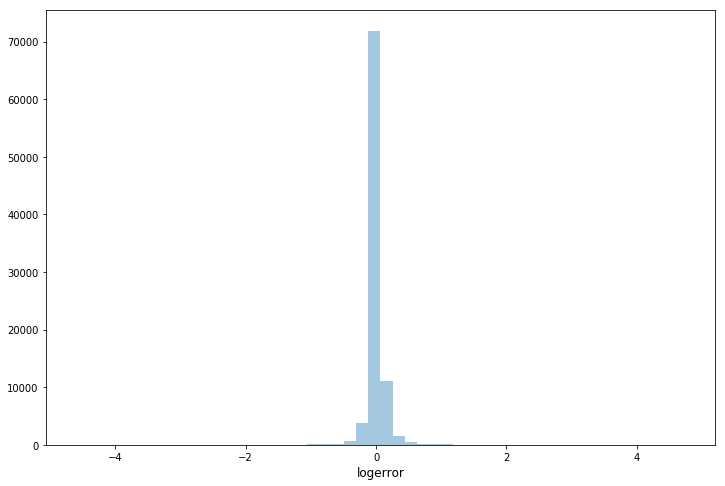

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Seems liked a peaked distribution, but outliers on log error are affecting the histogram.  Removing outliers:

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


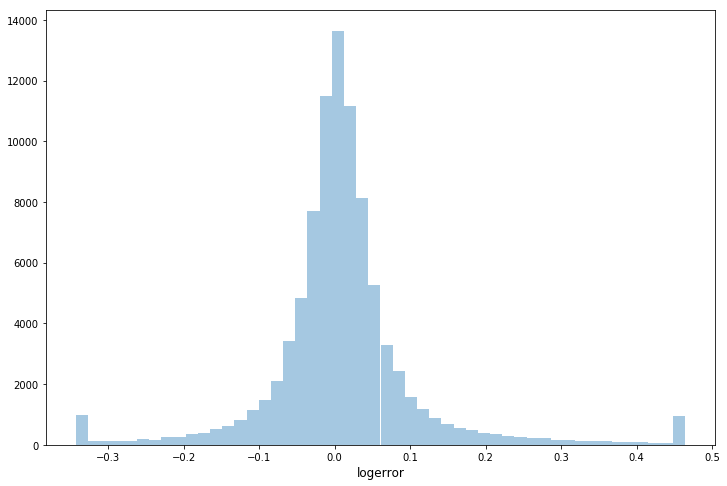

In [14]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Close to a normal distribution.  This shows why our test data of just predicting the mean did fairly ok.



<H5> Transaction Date </H5>

In [17]:
train_df.transactiondate.describe()

count                   90275
unique                    352
top       2016-07-29 00:00:00
freq                      910
first     2016-01-01 00:00:00
last      2016-12-30 00:00:00
Name: transactiondate, dtype: object

All the data is from 2016- we can aggregate it by month

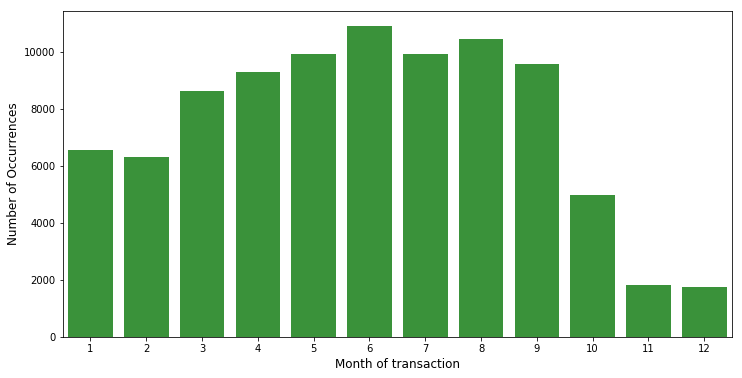

In [52]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
bars= sns.barplot(cnt_srs.index, cnt_srs.values,  color=color[2])
plt.xticks()
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Slow start of the year, then transactions pick up through August.  We do not have all the transactions after October 15th, per competition website.

<h5> Parcel ID </h5>

In [65]:
train_df['parcelid'].value_counts().reset_index()['parcelid'].value_counts()

ERROR! Session/line number was not unique in database. History logging moved to new session 319


1    90026
2      123
3        1
Name: parcelid, dtype: int64

Only 124 of the 90k+ properties had multiple transactions in this year period

<H5> Onto the Properties 2016 file <H5>

In [62]:
prop_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,811519.0,1.931166e+00,3.148587e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,6061.0,7.202607e+00,2.436290e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.700000e+01
basementsqft,1628.0,6.468833e+02,5.387935e+02,2.000000e+01,2.720000e+02,5.340000e+02,8.472500e+02,8.516000e+03
bathroomcnt,2973755.0,2.209143e+00,1.077754e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,2973767.0,3.088949e+00,1.275859e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.000000e+01
buildingclasstypeid,12629.0,3.725948e+00,5.017002e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,1938488.0,5.784787e+00,1.805352e+00,1.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
calculatedbathnbr,2856305.0,2.299263e+00,1.000736e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
decktypeid,17096.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


We can clearly see that a lot of these columns are missing data

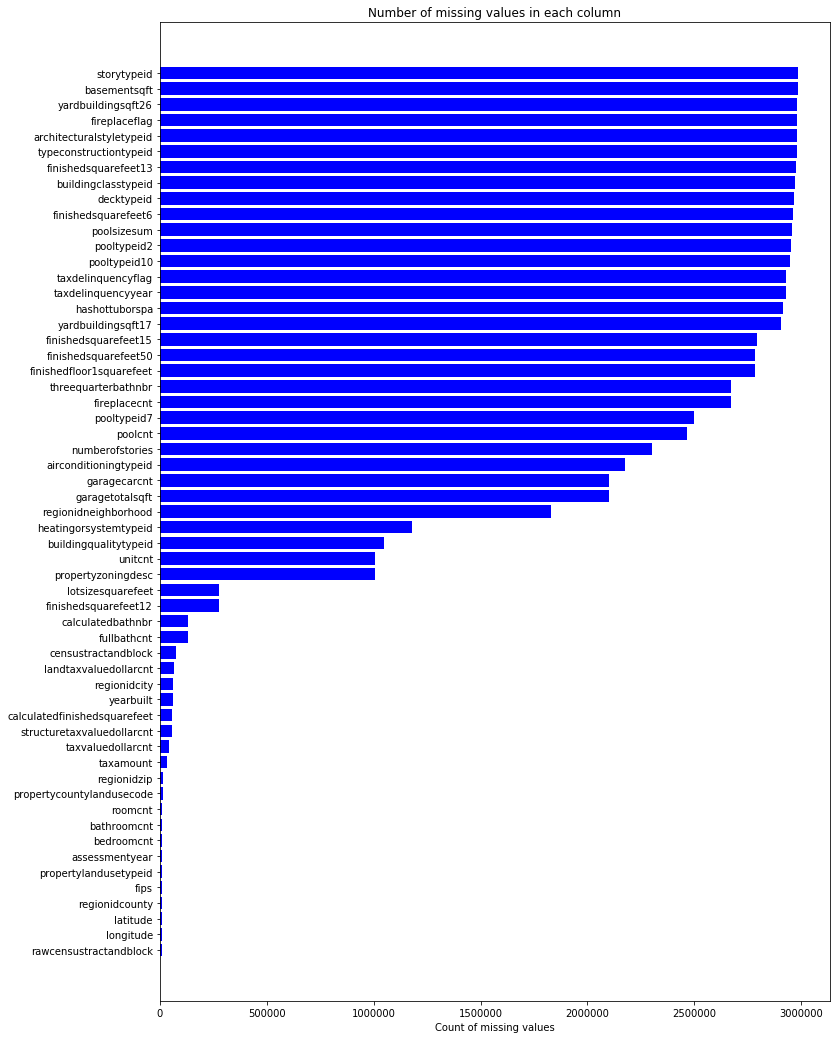

In [63]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

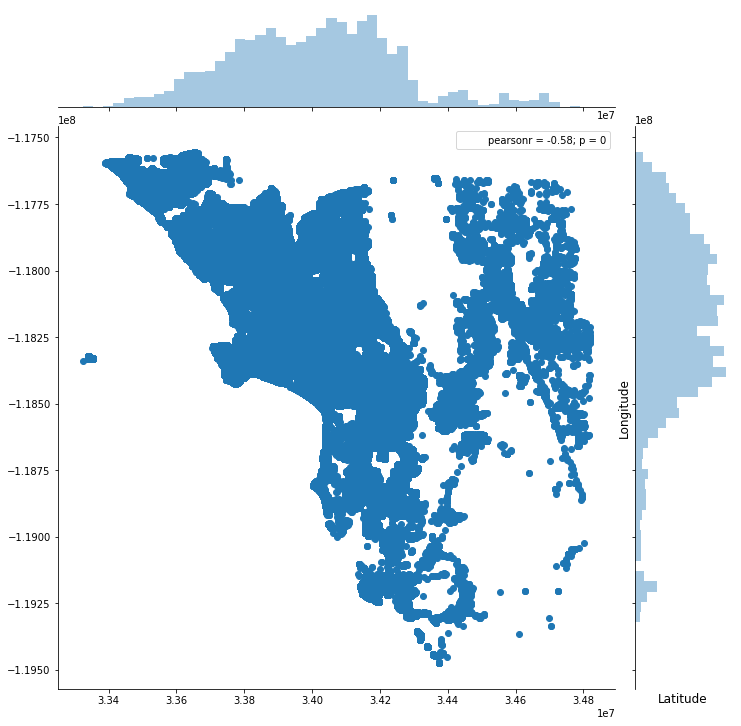

In [66]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

<h2> ML Start </h2>